In [29]:
from plyfile import PlyData
import numpy as np
import time
import matplotlib.pyplot as plt

def load_ply_file(file_path):
    with open(file_path, 'rb') as f:
        ply_data = PlyData.read(f)
    x_values = ply_data['vertex']['x']
    y_values = ply_data['vertex']['y']
    points = list(zip(x_values, y_values))

    return points

def generate_random_rectangle(vertices, epsilon=0.1):
    min_x, min_y = np.min(vertices, axis=0)
    max_x, max_y = np.max(vertices, axis=0)
    
    query_min_x = np.random.uniform(min_x - epsilon, max_x + epsilon)
    query_max_x = np.random.uniform(query_min_x, max_x + epsilon)
    query_min_y = np.random.uniform(min_y - epsilon, max_y + epsilon)
    query_max_y = np.random.uniform(query_min_y, max_y + epsilon)
    
    query_rectangle = np.array([[query_min_x, query_min_y], [query_max_x, query_max_y]])
    return query_rectangle

def naive_rectangle_query(vertices, query_rectangle):
    result_points = []
    for point in vertices:
        if query_rectangle[0, 0] <= point[0] <= query_rectangle[1, 0] and \
           query_rectangle[0, 1] <= point[1] <= query_rectangle[1, 1]:
            result_points.append(point)
    return np.array(result_points)

class Node:
    def __init__(self, point, left=None, right=None):
        self.point = point
        self.left = left
        self.right = right

def build_kd_tree(points, depth=0):
    if len(points) == 0:
        return None

    if len(points) == 1:
        return Node(points[0])

    # Sorting horzonatl and vertical
    if depth % 2 == 0:
        points.sort(key=lambda x: x[0]) 
    else:
        points.sort(key=lambda x: x[1])

    if len(points) % 2==0:
        median_index = (len(points) // 2) -1 # to make sure the lower value is closen to the left/ upper and on the split line
    else:
        median_index = len(points) // 2

    median_point = points[median_index]
#splitting it into 2 tree , left/right or above/below
    if depth % 2 == 0:
        P1 = points[:median_index]
        P2 = points[median_index + 1:]
    else:
        P1 = points[:median_index]
        P2 = points[median_index + 1:]

    left_child = build_kd_tree(P1, depth + 1)
    right_child = build_kd_tree(P2, depth + 1)

    return Node(median_point, left_child, right_child)

def visualize_kd_tree(node, ax, xmin, xmax, ymin, ymax, depth=0):
    if node is not None:
        linestyle = '--' if depth % 2 == 0 else '-' # for personal understanding of depth of the tree
        linewidth = 2 if depth == 0 else 1

        if depth % 2 == 0:
            ax.plot([node.point[0], node.point[0]], [ymin, ymax], linestyle, linewidth=linewidth, color='black', label=f'Depth {depth}')
            visualize_kd_tree(node.left, ax, xmin, node.point[0], ymin, ymax, depth + 1)
            visualize_kd_tree(node.right, ax, node.point[0], xmax, ymin, ymax, depth + 1)
        else:
            ax.plot([xmin, xmax], [node.point[1], node.point[1]], linestyle, linewidth=linewidth, color='black', label=f'Depth {depth}')
            visualize_kd_tree(node.left, ax, xmin, xmax, ymin, node.point[1], depth + 1)
            visualize_kd_tree(node.right, ax, xmin, xmax, node.point[1], ymax, depth + 1)

def search_kd_tree(node, range_rect, depth=0, result=[]):
    if node is not None:
        x, y = node.point

        if x >= range_rect[0][0] and x <= range_rect[1][0] and y >= range_rect[0][1] and y <= range_rect[1][1]:
            result.append(node.point)

        if depth % 2 == 0:
            if x > range_rect[0][0]:
                search_kd_tree(node.left, range_rect, depth + 1, result)
            if x <= range_rect[1][0]:
                search_kd_tree(node.right, range_rect, depth + 1, result)
        else:
            if y > range_rect[0][1]:
                search_kd_tree(node.left, range_rect, depth + 1, result)
            if y <= range_rect[1][1]:
                search_kd_tree(node.right, range_rect, depth + 1, result)

def check_results(result_naive,result_points):
    print("Length of kd tree",len(result_points))
    print("Length of naive way",len(result_naive))
    result_points.sort(key=lambda x: x[0])
    rows, cols = result_naive.shape

    if len(result_points) > 0:
        for i in range(rows):
            for j in range(cols):
                if result_points[i][j] != result_naive[i, j]:
                    print("not Equal")
                    return False  # Values are not equal
        print("Points found are the same in Kd Tree and the Naive algorithm")
        return True
    else:
        print(" No points found in the Query Rectangle")

Query Rectangle: [[3774.69395173 1088.84951443]
 [7275.91971449 3639.08023433]]
Time taken for naive rectangle query: 0.000908136367797851562500000000 seconds
Time taken to search the kd tree: 0.000000000000000000000000000000 seconds
Points in the query rect: [(4278.9742260831, 3286.0179115338), (3814.4181955934, 1556.5907485581), (4274.58172425, 1801.6130646512), (4143.6269588692, 3366.0026832996), (3780.1481684168, 2922.6465582152), (4257.3958950794, 2285.8197756921), (4161.4612407989, 3479.5007454862), (6571.6009285057, 1888.3728989811), (6492.6179038717, 1416.9296004218), (4974.2152084625, 1363.4771391542), (5413.3139635498, 1103.7684598341), (6027.1596364431, 1096.9254956585), (5774.0643222994, 2992.1364416704), (4873.596731548, 2357.9314319146), (4682.7132628312, 1444.2774703076), (4351.5767117737, 1993.2904405339), (4760.3222487682, 2028.0423631575), (4953.9177536191, 2809.3488668172), (5667.4677493737, 2701.7642110054), (5936.2881154047, 2656.3968022319), (6263.919280108, 2027.

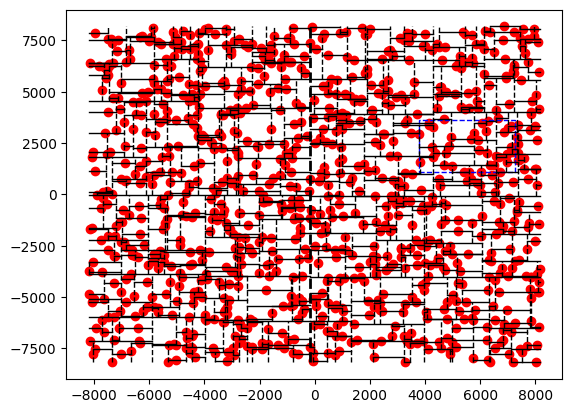

In [30]:
#ply file 
ply_file_path = 'C:/Users/Alcina Pinto/Desktop/COMP_GEO/DATASET/points/points_4.ply'
dataset = load_ply_file(ply_file_path)
result_points = []

#build kdtree
kd_tree_root = build_kd_tree(dataset)

#gen random rectangle
query_rect = generate_random_rectangle(dataset)
print("Query Rectangle:", query_rect)

#measure time for naive method of searching
start0 = time.time()
result_naive = naive_rectangle_query(dataset, query_rect)
end0 = time.time()
time_taken0 = "{:.30f}".format(end0 - start0)
print(f"Time taken for naive rectangle query: {time_taken0} seconds")

#measure time for searching in Kd Tree
start1 = time.time()
search_kd_tree(kd_tree_root, query_rect, result=result_points)
end1 = time.time()
time_taken1 = "{:.30f}".format(end1 - start1)
print(f"Time taken to search the kd tree: {time_taken1} seconds")

# Print the point in the query rect
print("Points in the query rect:", result_points)
if len(result_naive) > 0:
            result_array = result_naive[result_naive[:, 0].argsort()]
check_results( result_array,result_points)

# kd-Tree visualization
fig, ax = plt.subplots()
ax.scatter(*zip(*dataset), c='red', label='Points')
visualize_kd_tree(kd_tree_root, ax, min(p[0] for p in dataset), max(p[0] for p in dataset),
                  min(p[1] for p in dataset), max(p[1] for p in dataset))
ax.add_patch(plt.Rectangle(query_rect[0], query_rect[1][0] - query_rect[0][0],
                           query_rect[1][1] - query_rect[0][1], fill=False, linestyle='--', color='blue'))
plt.show()